In [1]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from ClusterDatasetTransformer import ClusterDataset
from training import *
from data_statistics import *

from IPython.display import display

from Transformer import Transformer
from lang import Lang
from LossFunction import Loss

2025-05-21 13:06:17.764652: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 13:06:17.785064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747825577.809749    4509 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747825577.816997    4509 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 13:06:17.843100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
input_length = 20
max_seq_length = 20
batch_size = 1
max_nodes = 66

In [4]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data/processed"
store_folder_training = "/eos/user/c/czeh/graph_data_trans"
data_folder_test = "/eos/user/c/czeh/graph_data_test/processed"
store_folder_test = "/eos/user/c/czeh/graph_data_trans_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(store_folder_training, data_folder_training, max_nodes=max_nodes, input_length=input_length)
dataset_test = ClusterDataset(store_folder_test, data_folder_test, max_nodes=max_nodes, input_length=input_length)

In [5]:
train_dl = DataLoader(dataset_training, shuffle=True, batch_size=batch_size)
test_dl = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)

In [6]:
converter = Lang(max_nodes)
vocab_size = converter.n_words

In [7]:
epochs = 5
d_model = 128
num_heads = 2
num_layers = 6
d_ff = 512
dropout = 0.1
feature_num = dataset_test.get(10).x.shape[1]

# Model, loss, and optimizer
model = Transformer(dataset_test.get(10).num_nodes+1, vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
# criterion = nn.CrossEntropyLoss(ignore_index=0)
# loss_obj = FocalLoss(alpha=0.45, gamma=2)
criterion = Loss(converter)


# Optionally introduce weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDatasetTransformer.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_di

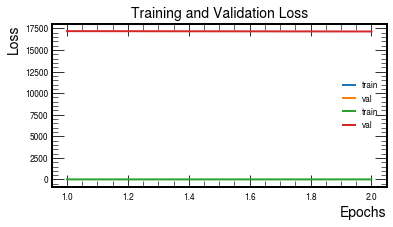

training:   0%|          | 0/15590 [00:00<?, ?it/s]/tmp/ipykernel_4509/1273920710.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor[i, :] = torch.tensor(sample[i].input, dtype=torch.long)
/tmp/ipykernel_4509/1273920710.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor[i, :] = torch.tensor(sample[i].y_trans, dtype=torch.long)
training:  96%|█████████▌| 14912/15590 [37:46<01:37,  6.92it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs

Epoch 2, Loss: 11.052216


test: 100%|██████████| 4992/4992 [06:13<00:00, 13.38it/s]


Epoch 2, Val Loss: 11.052216


training:  59%|█████▊    | 9125/15590 [21:43<14:25,  7.47it/s]  

In [ ]:
train_loss_hist = []
val_loss_hist = []
# Optionally introduce gradient clipping
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 10

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

display_loss = display(1, display_id=True)

optimizer.zero_grad()
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    val_loss = 0
    for sample in tqdm(train_dl, desc="training"):
        input_tensor = torch.zeros((batch_size, input_length), dtype=torch.long).to(device)
        target_tensor = torch.zeros((batch_size, input_length), dtype=torch.long).to(device)
        edge_tensor = torch.zeros((batch_size, sample.x.shape[0], feature_num), dtype=torch.float).to(device)

        for i in range(batch_size):
            input_tensor[i, :] = torch.tensor(sample[i].input, dtype=torch.long)
            target_tensor[i, :] = torch.tensor(sample[i].y_trans, dtype=torch.long)
            edge_tensor[i, :] = torch.unsqueeze(sample.x, dim=0).float()

        output = model(edge_tensor, input_tensor)
        loss = criterion(output.contiguous().view(-1, vocab_size), target_tensor.contiguous().view(-1), output.argmax(-1)[0, -1].item(), sample[i].input, sample[i].group)
#         loss = criterion(output.contiguous().view(-1, vocab_size), target_tensor.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    loss = total_loss / len(test_dl)
    print(f"Epoch {epoch+1}, Loss: {loss:.6f}")
    train_loss_hist.append(loss)
    
    model.eval()
    for sample in tqdm(test_dl, desc="test"):
        input_tensor = torch.zeros((1, input_length), dtype=torch.long).to(device)
        target_tensor = torch.zeros((1, input_length), dtype=torch.long).to(device)
        edge_tensor = torch.zeros((1, sample.x.shape[0], feature_num), dtype=torch.float).to(device)

        input_tensor[0, :] = torch.tensor(sample[i].input, dtype=torch.long)
        target_tensor[0, :] = torch.tensor(sample[i].y_trans, dtype=torch.long)
        edge_tensor[0, :] = torch.unsqueeze(sample.x, dim=0).float()

        predictions = model(edge_tensor, input_tensor)
        predicted_index = predictions.argmax(-1)
        predicted_number = predicted_index[0, -1].item()
        
        output = model(edge_tensor, input_tensor)
        loss = criterion(output.contiguous().view(-1, vocab_size), target_tensor[0].contiguous().view(-1), output.argmax(-1)[0, -1].item(), sample[i].input, sample[i].group)
#         loss = criterion(output.contiguous().view(-1, vocab_size), target_tensor.contiguous().view(-1))    
        val_loss += loss.item()
        
    loss = total_loss / len(test_dl)
    print(f"Epoch {epoch+1}, Val Loss: {loss:.6f}")
    val_loss_hist.append(val_loss)
    
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss)
    display_loss.update(fig_loss)
    time.sleep(1)
        
        
        
    # Early stopping
#     if loss < best_loss:
#         best_loss = val_loss
#         best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
#         patience = 10  # Reset patience counter
#     else:
#         patience -= 1
#         if patience == 0:
#             break
            
# Load the best model weights
# model.load_state_dict(best_model_weights)

In [ ]:
correct = 0
model.eval() 
torch.no_grad()
i = 0
for sample in tqdm(test_dl, desc="test"):
    input_tensor = torch.zeros((1, input_length), dtype=torch.long).to(device)
    target_tensor = torch.zeros((1, input_length), dtype=torch.long).to(device)
    edge_tensor = torch.zeros((1, sample.x.shape[0], feature_num), dtype=torch.float).to(device)

    input_tensor[0, :] = torch.tensor(sample[i].input, dtype=torch.long)
    target_tensor[0, :] = torch.tensor(sample[i].y_trans, dtype=torch.long)
    edge_tensor[0, :] = torch.unsqueeze(sample.x, dim=0).float()
            
    predictions = model(edge_tensor, input_tensor)
    predicted_index = predictions.argmax(-1)
    predicted_number = predicted_index[0, -1].item()
#     res = torch.roll(input_tensor, predicted_number, dims=1)

#     step = 0
#     while (predicted_number != 2 and step < 100):  # Disable gradient computation for inference
#         input_tensor = torch.roll(input_tensor, -1, dims=1)
#         input_tensor[0, -1] = predicted_number
    
#         predictions = model(edge_tensor, input_tensor)
#         predicted_index = predictions.argmax(-1)  # Get the index of the max log-probability for the last position
#         predicted_number = predicted_index[0, -1].item()  # Convert to Python number
#         res.append(predicted_number)
#         step += 1
     
#     input_tensor = torch.roll(input_tensor, -1, dims=1)
#     input_tensor[0, -1] = predicted_number 
#     check = converter.arr2seq(input_tensor[0]) == converter.arr2seq(converter.subseq2arr(sample[0].y, input_length, 0, input_length))
    
    print(f"Input Sequence: {sample[0].input}")
    print(f"Predicted: {predicted_number}")
    print(f"Real: {sample[i].y_trans[-1]}")
#     print(f"Predicted Sequence: {converter.seq2y(np.array(res.cpu()))}")
#     print(f"Correct: {check}")
    
#     try:
#         origG = torch_geometric.utils.to_networkx(sample, to_undirected=True)
#         res_nodes, res_edges = sequenceToGraph(converter.arr2seq(input_tensor[0], ignoreTokens=True))
#         newData = Data(x=sample.x, num_nodes=sample.num_nodes, edge_index=torch.from_numpy(res_edges))
#         G = torch_geometric.utils.to_networkx(newData, to_undirected=True)

#         fig, ax = plt.subplots(1, 2)
#         nx.draw_circular(origG, with_labels=True, ax=ax[0])
#         nx.draw_circular(G, with_labels=True, ax=ax[1])
#     except:
#         print("incorrect sequence")
    
    
#     correct += check

# print(f"Percentage of correct guesses: {correct / (len(test_dl))}")

In [ ]:
# torch.save({'epoch': epoch+1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'training_loss': loss
#             }, "/eos/user/c/czeh/tranformer.pt")
